In [1]:
# Autoreload
%load_ext autoreload
%autoreload 2

In [2]:
# Imports
import numpy as np
import json
import pandas as pd
import numpy as np
import time
import string
from matplotlib import pyplot as plt
import tensorflow as tf
import sys
sys.path.append('../../../')
from brain2brain import utils, generators, models
%matplotlib inline

# TF
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# TCN
from brain2brain.tcn import TCN
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Flatten, GRU, LSTM, RepeatVector, TimeDistributed

from scipy.stats import pearsonr

# Encoder-Decoder With Teacher Forcing

In [3]:
train_paths = utils.get_file_paths("/home/tmarcu/brain2brain/brain2brain/train_676_bin_norm_2.txt")
val_paths = utils.get_file_paths("/home/tmarcu/brain2brain/brain2brain/val_676_bin_norm_2.txt")
total_electrode_count = utils.get_file_shape(train_paths[0])[1]
# Electrodes
electrode_count = 1
# Training Generator
train_generator = generators.FGenerator(file_paths=train_paths,
                                        lookback=50,
                                        length=5,
                                        delay=0,
                                        batch_size=1024,
                                        sample_period=1,
                                        electrodes=[5],
                                        electrode_output_ix=5,
                                        shuffle=True,
                                        teacher_forcing=True)
# Validation Generator
val_generator = generators.FGenerator(file_paths=val_paths,
                                        lookback=50,
                                        length=5,
                                        delay=0,
                                        batch_size=1024,
                                        sample_period=1,
                                        electrodes=[5],
                                        electrode_output_ix=5,
                                        shuffle=False,
                                        teacher_forcing=True)

(5429, 114)


# Machine Learning Mastery Model

In [3]:
dropout = .005
n_features = 1
n_units = 128
# define model
train, infenc, infdec = models.define_enc_dec_model(n_features, n_features, n_units)
train.compile(optimizer='adam', loss='mae')
train.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 128), (None, 66560       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 128),  66560       input_2[0][0]                    
                                                                 lstm[0][1]                   

In [6]:
callback_list = [
        EarlyStopping(
            monitor="val_loss",
            patience=2,
            mode="min"
        )
]
history = train.fit_generator(generator=train_generator,
                              callbacks=callback_list,
                              epochs=100,
                              validation_data=val_generator)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 28 steps, validate for 9 steps
Epoch 1/100
28/28 [==============================] - 30s 1s/step - loss: 1.1079 - val_loss: 1.0932
Epoch 2/100
28/28 [==============================] - 19s 668ms/step - loss: 1.1079 - val_loss: 1.0932
Epoch 3/100
28/28 [==============================] - 19s 663ms/step - loss: 1.1079 - val_loss: 1.0932


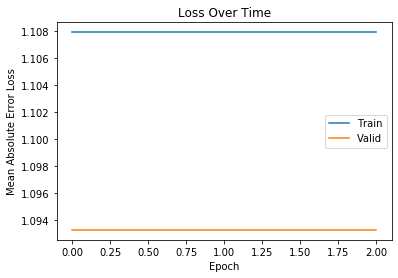

In [7]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

# Joseph Eddy Model

In [4]:
hidden_units = 128
dropout = 0.05
train_2, inf_encoder_model, inf_decoder_model = models.define_enc_dec_model_jeddy_o2o(hidden_units, dropout)

In [5]:
train_2.compile(optimizer='adam', loss='mae')
train_2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 128), (None, 66560       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 128),  66560       input_2[0][0]                    
                                                                 lstm[0][1]                   

In [6]:
callback_list = [
        EarlyStopping(
            monitor="val_loss",
            patience=2,
            mode="min"
        )
]
history = train_2.fit_generator(generator=train_generator,
                              callbacks=callback_list,
                              epochs=100,
                              validation_data=val_generator)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 28 steps, validate for 9 steps
Epoch 1/100
28/28 [==============================] - 10s 344ms/step - loss: 0.5721 - val_loss: 0.5242
Epoch 2/100
28/28 [==============================] - 5s 176ms/step - loss: 0.5245 - val_loss: 0.5083
Epoch 3/100
28/28 [==============================] - 5s 172ms/step - loss: 0.5105 - val_loss: 0.4972
Epoch 4/100
28/28 [==============================] - 5s 173ms/step - loss: 0.5014 - val_loss: 0.4896
Epoch 5/100
28/28 [==============================] - 5s 173ms/step - loss: 0.4968 - val_loss: 0.4860
Epoch 6/100
28/28 [==============================] - 5s 174ms/step - loss: 0.4962 - val_loss: 0.4850
Epoch 7/100
 4/28 [===>..........................] - ETA: 4s - loss: 0.5022WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss


KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [ ]:
from tensorflow.keras.models import model_from_json

file_name = "models/enc_dec_1"
# serialize model to JSON
model_json = model.to_json()
with open(f"{file_name}.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights(f"{file_name}.h5")


In [ ]:
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ix, pred_steps: int, enc_tail_len=50):
    encode_series = encoder_input_data[0][sample_ix:sample_ix+1,:,:] 
    pred_series = models.decode_sequence_o2o(inf_encoder_model,
                                             inf_decoder_model, 
                                             input_seq=encode_series,
                                             pred_steps=pred_steps)
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ix,:,:1].reshape(-1,1)
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    r, p = pearsonr(pred_series.reshape(-1), target_series.reshape(-1))
    print(f"Correlation: {r}. P: {p}")
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])

In [ ]:
val_batch = val_generator[0]

In [ ]:
len(val_batch[0][0])

In [ ]:
predict_and_plot(val_batch[0], val_batch[1], sample_ix=0, pred_steps=5)

In [ ]:
def get_corr_mae(encoder_input_data, decoder_target_data, sample_ix, pred_steps: int,
                 enc_tail_len=50, verbose=True):
    encode_series = encoder_input_data[0][sample_ix:sample_ix+1,:,:] 
    pred_series = models.decode_sequence_o2o(inf_encoder_model,
                                             inf_decoder_model, 
                                             input_seq=encode_series,
                                             pred_steps=pred_steps)
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ix,:,:1].reshape(-1,1)
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    r, p = pearsonr(pred_series.reshape(-1), target_series.reshape(-1))
    mae = np.mean(np.abs(pred_series.reshape(-1) - target_series.reshape(-1)))
    if verbose:
        print(f"Correlation: {r}. P: {p}. MAE: {mae}")
    return r, mae

In [ ]:
n_rows = val_batch[0][0].shape[0]
r_array = np.empty(shape=(n_rows,))
z_array = np.empty(shape=(n_rows,))
sample_maes = np.empty(shape=(n_rows,))
for sample_ix in range(n_rows):
    print(f"Sample: {sample_ix}/{n_rows}", end="\r")
    r, mae = get_corr_mae(val_batch[0], val_batch[1], sample_ix=sample_ix, pred_steps=5, verbose=False)
    r_array[sample_ix] = r
    z_array[sample_ix] = 0.5 * np.log((1 + r)/(1-r))
    sample_maes[sample_ix] = mae
z_mean = np.mean(z_array)
batch_r = (np.exp(2 * z_mean) - 1)/(np.exp(2 * z_mean) + 1)
batch_mae = np.mean(sample_maes)
print(f"Batch_r: {batch_r}")
print(f"Absolute Batch_r: {np.mean(np.abs(r_array))}")
print(f"Batch Mae: {batch_mae}")

# Predict 10 Timesteps

In [3]:
train_paths = utils.get_file_paths("/home/tmarcu/brain2brain/brain2brain/train_676_bin_norm_2.txt")
val_paths = utils.get_file_paths("/home/tmarcu/brain2brain/brain2brain/val_676_bin_norm_2.txt")
total_electrode_count = utils.get_file_shape(train_paths[0])[1]
# Electrodes
electrode_count = 1
electrode = 5
# Training Generator
train_generator = generators.FGenerator(file_paths=train_paths,
                                        lookback=50,
                                        length=10,
                                        delay=0,
                                        batch_size=1024,
                                        sample_period=1,
                                        electrodes=[electrode],
                                        electrode_output_ix=electrode,
                                        shuffle=True,
                                        teacher_forcing=True)
# Validation Generator
val_generator = generators.FGenerator(file_paths=val_paths,
                                        lookback=50,
                                        length=10,
                                        delay=0,
                                        batch_size=1024,
                                        sample_period=1,
                                        electrodes=[electrode],
                                        electrode_output_ix=electrode,
                                        shuffle=False,
                                        teacher_forcing=True)

(5429, 114)


In [4]:
val_generator[0][1].shape

(1024, 10, 1)

In [5]:
hidden_units = 128
dropout = 0.05
train_3, inf_encoder_model_3, inf_decoder_model_3 = models.define_enc_dec_model_jeddy_o2o(hidden_units, dropout)

In [6]:
train_3.compile(optimizer='adam', loss='mae')
train_3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 128), (None, 66560       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 128),  66560       input_2[0][0]                    
                                                                 lstm[0][1]                   

In [7]:
callback_list = [
#         EarlyStopping(
#             monitor="val_loss",
#             patience=5,
#             mode="min"
#         )
]
history_3 = train_3.fit_generator(generator=train_generator,
                              callbacks=callback_list,
                              epochs=170,
                              validation_data=val_generator)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 25 steps, validate for 8 steps
Epoch 1/170
25/25 [==============================] - 11s 439ms/step - loss: 0.5704 - val_loss: 0.5259
Epoch 2/170
25/25 [==============================] - 5s 199ms/step - loss: 0.5248 - val_loss: 0.5102
Epoch 3/170
25/25 [==============================] - 5s 200ms/step - loss: 0.5094 - val_loss: 0.5041
Epoch 4/170
25/25 [==============================] - 6s 225ms/step - loss: 0.5000 - val_loss: 0.4899
Epoch 5/170
25/25 [==============================] - 5s 201ms/step - loss: 0.4953 - val_loss: 0.4864
Epoch 6/170
25/25 [==============================] - 5s 213ms/step - loss: 0.4944 - val_loss: 0.4860
Epoch 7/170
25/25 [==============================] - 5s 212ms/step - loss: 0.4947 - val_loss: 0.4856
Epoch 8/170
25/25 [==============================] - 5s 218ms/step - loss: 0.4943 - val_loss: 0.4854
Epoch 9/170
25/25 [=====

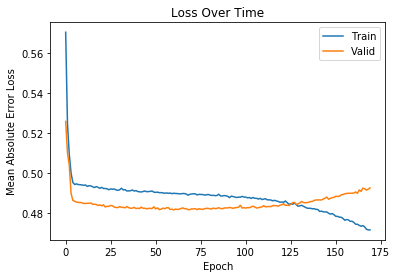

In [8]:
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [ ]:
from tensorflow.keras.models import model_from_json

file_name = "models/enc_dec_2"
# serialize model to JSON
model_json = model.to_json()
with open(f"{file_name}.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights(f"{file_name}.h5")


In [9]:
val_batch = val_generator[0]

In [10]:
len(val_batch[0][0])

1024

Correlation: 0.6052381385463943. P: 0.06372833183920691


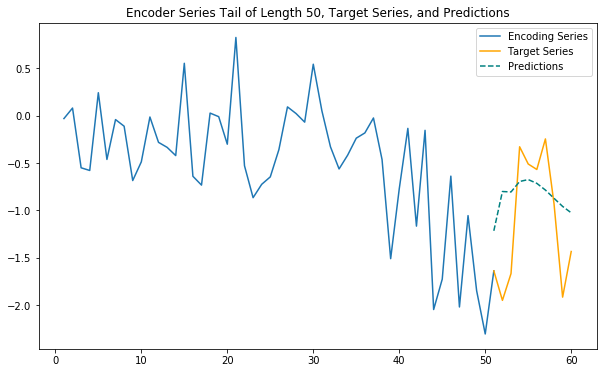

In [11]:
utils.predict_and_plot(inf_encoder_model_3, inf_decoder_model_3,
                       val_batch[0], val_batch[1], sample_ix=0,
                       pred_steps=10)

In [13]:
print("Calculating MAE/CORR per batch.")
batch_ix = 0
val_batch = val_generator[batch_ix] 
n_rows = val_batch[0][0].shape[0]
r_array = np.empty(shape=(n_rows,))
sample_maes = np.empty(shape=(n_rows,))
for sample_ix in range(n_rows):
    print(f"Sample: {sample_ix}/{n_rows}", end="\r")
    r, mae = utils.get_corr_mae(inf_encoder_model_3, inf_decoder_model_3,
                          val_batch[0], val_batch[1], sample_ix=sample_ix,
                          pred_steps=10, verbose=False)
    r_array[sample_ix] = r
    sample_maes[sample_ix] = mae
z_mean = np.mean(r_array)
batch_r = np.tanh(z_mean)
batch_mae = np.mean(sample_maes)
print(f"Batch_r: {batch_r}")
print(f"Batch Mae: {batch_mae}")

Calculating MAE/CORR per batch.
Batch_r: 0.061847071004116856
Batch Mae: 0.5852524357304423


In [17]:
print(sample_maes.argsort())
print(r_array.argsort())

[238 955 221 ... 570 435 882]
[980 288 667 ... 634 648 774]


Correlation: 0.21789377294665904. P: 0.5453499037373094


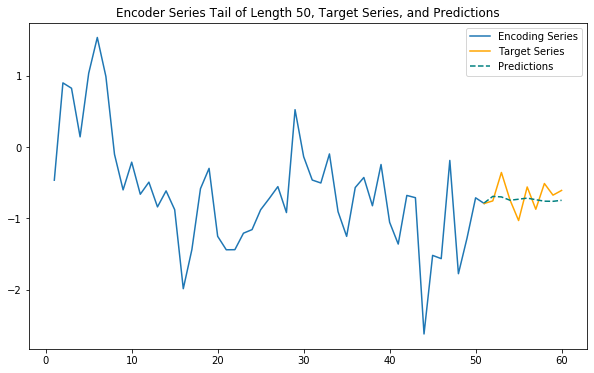

In [18]:
utils.predict_and_plot(inf_encoder_model_3, inf_decoder_model_3,
                       val_batch[0], val_batch[1], sample_ix=238,
                       pred_steps=10)

Correlation: -0.8969370017386968. P: 0.0004351506568805077


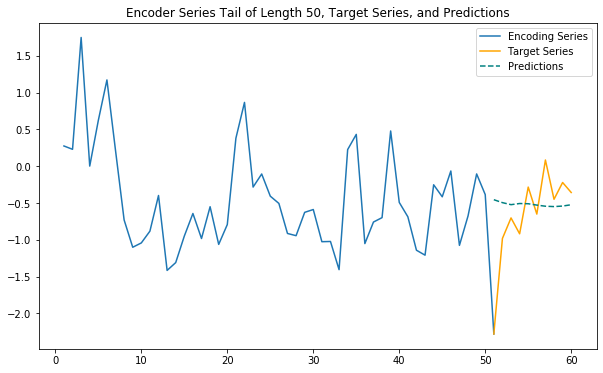

In [19]:
utils.predict_and_plot(inf_encoder_model_3, inf_decoder_model_3,
                       val_batch[0], val_batch[1], sample_ix=980,
                       pred_steps=10)